<a href="https://colab.research.google.com/github/PoiZeX/CloudCourse/blob/main/ex6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install firebase



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


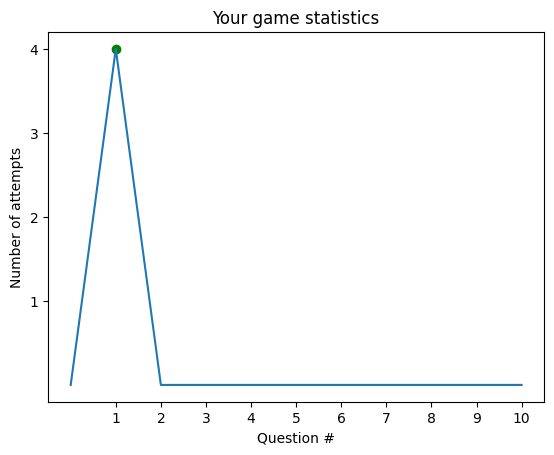

In [9]:
from ipywidgets.widgets.widget_button import ButtonStyle
#@title
import time
from ipywidgets.widgets.widget_style import Style
from zmq.constants import NULL
from firebase import firebase
from IPython.display import display
import IPython
from google.colab import output
import random
import ipywidgets as widgets
from IPython.display import display, HTML, clear_output
from ipywidgets import VBox, HBox, HTML, Layout, Box, Label
import matplotlib.pyplot as plt
import math
import re




##########################################################################################################################
############################################### CONFIGURATION <-  ########################################################
##########################################################################################################################

FIREBASE_PATH = 'https://ex6game-default-rtdb.europe-west1.firebasedatabase.app/'
style = {'description_width': '150px'} 
box_layout = widgets.Layout(display='flex',  flex_flow='column',  align_items='center',  width='100%')
################################################################################
#################################### CLASSES ###################################
################################################################################
class Question():
  answers = []
  def __init__(self, question, lst_options, correct):
    self.question = question
    self.answers = lst_options[1:]
    self.correct = correct
  
  def isCorrect(self, str_option):
    correctAns = self.answers[int(self.correct)-1]
    return str_option == str(correctAns)
  
  def get_random_answers(self):
      return random.sample(self.answers, len(self.answers))
  
  def get_question_str(self):
    return self.question

  def get_all_answers(self):
    return self.answers

  def get_correct_inx(self):
    return self.correct




  def set_question_str(self, question_str):
    self.question = question_str

  def set_answers(self, answers_lst):
    self.answers = answers_lst

  def set_correct(self, correct_inx):
    self.correct = correct_inx

################################################################################
class QuestionsDB():
  lst_questions = []
  current_question = None
  original_questions_lst = []

  def __init__(self, lst_questions):
    self.lst_questions = [Question(item['question'], item['answers'], item['correctAnswer']) for item in lst_questions if item is not None]
    self.original_questions_lst = self.lst_questions.copy()

  def get_random_question(self):
    global randomQuestionAndAnswer, answers, question, radioButtonLst
    randomQuestionAndAnswer = NULL # we want to generate new item...
    if self.lst_questions:
      random_question = random.sample(self.lst_questions, 1)[0]
      self.lst_questions.remove(random_question)
      self.current_question = random_question
      return random_question
    else:
      self.current_question = []
      return
   
  def add_question_to_DB(self):
    pass

  def remove_question_from_DB(self, question):
   # Remove the module from the Firebase database
    FBconn = firebase.FirebaseApplication(FIREBASE_PATH, None)
    res = FBconn.get('/Questions', None)

    count = -1 
    if res:
        for key in res:
            count = count + 1
            if (key):
                if key['question'] == question.get_question_str():
                    # remove_url = f'/Questions/{count}'
                    # FBconn.delete(remove_url, None)
                    print("Collection removed successfully from the database.")
                    break
        else:
            print("Failed to find the collection in the database.")

    # Remove the module from the local list
    for module in self.lst_questions:
        if module.get_question_str() == question.get_question_str():
            self.lst_questions.remove(module)
            self.original_questions_lst = self.lst_questions
            break
    else:
        print("Failed to find the module in the local list.")

  def get_num_of_questions(self):
    return len(self.lst_questions)
  
  def get_original_len(self):
    return len(self.original_questions_lst)

  def get_all_questions(self):
    return self.original_questions_lst



  def get_current_question_obj(self):
    return self.current_question
################################################################################
class User():
  def __init__(self, username, password, role):
    self.username = username
    self.password = password
    self.role = role
  
  def isAdmin(self):
    return self.role == "Admin"
  
  def getName(self):
    return self.username

##########################################################################################################################
#############################################  FIREBASE #################################################################
##########################################################################################################################
def get_questions_from_db():
  global questionsFromDB
  FBconn = firebase.FirebaseApplication(FIREBASE_PATH,None)
  res = FBconn.get('/Questions/',None)

  if res:
    # insert questions to DB class
    questionsFromDB = QuestionsDB([question for question in res])


##########################################################################################################################
######## GLOBAL VARIABLES
##########################################################################################################################
questionsFromDB = None
btn_go_back = widgets.Button(description="Back", button_style="primary",layout=Layout(width="80px"))
current_user = NULL
points = 0
quantity_of_questions=0
quantity_of_correct_questions=0
list_of_stats = []  # will be filled with number of attempts for EACH question
question = ""
buttonsLst = []
NumberOfQuestionsToPlay = 1
#For Admin Form 
#--->
cb_correctAnswerId = NULL
tb_question= NULL
tb_answer1 = NULL
tb_answer2 = NULL
tb_answer3 = NULL
tb_answer4 = NULL
offset = 0
#<---

##########################################################################################################################
########################################################## UTILS #########################################################
##########################################################################################################################
from enum import Enum
class WidgetEnum(Enum):
    BUTTON = 1
    LABEL = 2     
    TEXTBOX = 4 
    PASSWORD = 8 

def show_h2_center_text(text):
  """
  Generic function for h2 centered text
  """
  display(IPython.display.HTML(f"<div style='text-align: center; justify-content: center; align-items: center;'>"+
    f"<h2>{text}</h2><br/>"))

def show_h4_center_text(text):
  """
  Generic function for h4 centered text
  """
  display(IPython.display.HTML(f"<div style='text-align: center; justify-content: center; align-items: center;'>"+
    f"<h4>{text}</h4><br/>"))
  

def create_widget(widget_enum, description, button_style = "", layout="", onclick=""):
  b_layout = widgets.Layout( width='auto', height='auto', min_width="150px", margin="20px 0px 0px 110px")
  b_style={'white_space': 'pre-wrap'}
  style = {'description_width': '150px'} 
  
  obj = None
  if widget_enum == WidgetEnum.BUTTON:
    if layout != "":
      b_layout = layout
    obj = widgets.Button(description = str(description), button_style = button_style,layout = b_layout, style=b_style)
    if onclick != "":
        obj.on_click(onclick)

  elif widget_enum == WidgetEnum.LABEL:
    return None

  elif widget_enum == WidgetEnum.PASSWORD:
      obj = widgets.Password(description=description, style=style) 
  
  elif widget_enum == WidgetEnum.TEXTBOX:
      obj = widgets.Text(description=description, style=style) 
      
  else:
    return None

  return obj

def center_widgets(widgets_lst):
  """
  gets a list of widgets and centered them
  """
  return widgets.HBox(children=widgets_lst,layout=box_layout)

def show_go_back(back_event):
  if btn_go_back != NULL:
    display(btn_go_back)
    btn_go_back.on_click(back_event)


##########################################################################################################################
################################### RESULTS SECTION -> SHOWS THE RESULTS AND GRAPH <-  ###################################
##########################################################################################################################


def show_statistics_chart():
  """
  Generate and show statistics plot. 
  The statistics are number of attempts for each question
  """
  global list_of_stats
  list_of_stats.insert(0, 0) # normalize the data
  fig, ax = plt.subplots() # configure
  
  ax.plot(list_of_stats) # make the line plot

  # mark the dots
  for i, stat in enumerate(list_of_stats):
    if stat != 0:
        ax.scatter(i, stat, color='green', marker='o')

  # make data readable (start from 1)
  ax.set_xticks(range(1, len(list_of_stats))) 
  ax.set_yticks(range(1, 5))

  ax.set_title("Your game statistics")
  ax.set_ylabel("Number of attempts")
  ax.set_xlabel("Question #")
  
  plt.show()

def show_results_page():
    good_words = ""
    badge_src = ""
    btn_return_menu = create_widget(WidgetEnum.BUTTON, "Return to Menu", onclick=show_menu_page)
    btn_return_menu.style.button_color = 'green'
    btn_return_menu.layout.margin = "50px auto 0px auto" 

    total_score_to_earn = 3*questionsFromDB.get_num_of_questions()
    name = current_user.getName()
    if total_score_to_earn < 2:
      good_words = f"{name}, You are AWESOME!"
      badge_src = "https://thumbs.dreamstime.com/z/gold-medal-st-place-badge-symbol-victory-sport-business-gold-medal-st-place-badge-symbol-victory-sport-business-128259723.jpg"
    elif total_score_to_earn - points < 15:
      good_words = f"{name}, You are great! Try again to beat yourself "
      badge_src = "https://c8.alamy.com/comp/JE56PM/silver-2st-place-medal-vector-metal-realistic-badge-with-second-placement-JE56PM.jpg"
    else:
      good_words = f"{name}, You are good, but need more practice. try out our courses and play again"
      badge_src = "https://thumbs.dreamstime.com/b/award-badge-third-place-red-ribbon-isolated-medal-pin-symbol-realistic-d-design-victory-trophy-sign-number-white-147089746.jpg"
    succ_percentages = round((points/total_score_to_earn)*100)
    display(IPython.display.HTML(f"<div style='text-align: center; justify-content: center; align-items: center;'>"+
    f"<h2 style='color: red'><img src='https://www.animatedimages.org/data/media/492/animated-fireworks-image-0087.gif' style='width: 50px; height: 50px'/>"+
                                f"Game over!<img src='https://www.animatedimages.org/data/media/492/animated-fireworks-image-0087.gif' style='width: 50px; height: 50px'/></h2>"+
    f"<h4><u>Your score</u></h4><br/><strong>Points:</strong> {points} | "+
    f"<strong>Correct answers:</strong> {quantity_of_correct_questions}"
    f"<br/><strong>You could earn up to</strong> {total_score_to_earn} points."+
    f"<br/><strong>Your success rate is:</strong> {succ_percentages}%"+
    
    f"<h4 style='color: #00bfff;'>{good_words}</h4><br/>"+
    f"<div>You earn a new badge: <img src={badge_src} style='width: 150px; height: 150px; justify-content: center; align-items: center; '/></div></div>"),
    center_widgets([HBox([btn_return_menu])]))  # Display the return to menu button
    show_statistics_chart()

##################################################################################################################################
################################### GAME SECTION -> QUESTION PROGRESS FROM START TO FINISH <-  ###################################
##################################################################################################################################

progress_bar = widgets.IntProgress(
    value=0,
    min=0,
    max=NumberOfQuestionsToPlay,
    description='Progress:',
    bar_style='info',
    style={'bar_color': 'blue'},
    orientation='horizontal'
)

def reset_game():
    global points, quantity_of_questions, quantity_of_correct_questions, list_of_stats, questionsFromDB
    points = 0
    quantity_of_questions = 0
    quantity_of_correct_questions = 0
    list_of_stats = []
    questionsFromDB = None
    progress_bar.value=0

def game_over(btn=NULL):
  output.clear()
  show_results_page()
  reset_game()

#create stop btn
btn_stop_game = create_widget(WidgetEnum.BUTTON, "Stop Game", onclick=game_over)
btn_stop_game.style.button_color = 'red'
btn_stop_game.layout.margin = "10px auto 0 auto"
btn_stop_game.layout.width = "150px"
container = widgets.Box([btn_stop_game], layout=widgets.Layout(justify_content='flex-end', width='100%'))


def display_questions():
  """
  Create questions page elemnts and show them
  """
  global randomQuestionAndAnswer, answers, question, radioButtonLst

  current_question = questionsFromDB.get_current_question_obj()

  display(IPython.display.HTML(f"<h2 style='display: flex; justify-content: center; align-items: center;'>{current_question.get_question_str()}</h2>"))
  points_label = HTML(f"<strong>Points:</strong> {points}")
  correct_label = HTML(f"<strong>Correct Questions:</strong> {quantity_of_correct_questions}")
  total_label = HTML(f"<strong>Out Of:</strong> {quantity_of_questions}")

  box = widgets.HBox(children=[points_label, correct_label, total_label],layout=box_layout)
  display(box)
  
  buttonsLst = [create_widget(WidgetEnum.BUTTON, str(answer), onclick=on_answer_button_clicked)\
                      for answer in current_question.get_random_answers()]

  for btn in buttonsLst:
    btn.style.button_color = 'orange'

  left_box = VBox([buttonsLst[0], buttonsLst[1]])
  right_box = VBox([buttonsLst[2], buttonsLst[3]])
  
  display(center_widgets([HBox([left_box, right_box])]))
  display(container)
  display(progress_bar)

def show_questions_page():
  """
  Generate a new question
  """
  global show_go_back
  output.clear()
  questionsFromDB.get_random_question()
  display_questions()
  btn_go_back.description = "Exit game"
  show_go_back(show_menu_page)  

def on_answer_button_clicked(b):
    """
    The true logic for answer button clicked
    """
    global list_of_stats, NumberOfQuestionsToPlay
    update_total_questions_quantity()

    list_of_stats[questionsFromDB.get_original_len() - questionsFromDB.get_num_of_questions() - 1] += 1


    if b.description == "Stop Game":
        game_over()
        return

    # check if user's answer is correct
    
    if questionsFromDB.current_question.isCorrect(str(b.description)):
        update_points(3)
        update_total_correct_questions_quantity()
        print("Correct!")
        b.style.button_color = 'lightgreen'

        # start timer and refresh
        time.sleep(1.5)
        update_total_questions_quantity()
        if questionsFromDB.get_original_len() - questionsFromDB.get_num_of_questions() == NumberOfQuestionsToPlay:
          game_over()
          return
        else:
          show_questions_page()
    else:
        update_points(-1)
        b.style.button_color = 'red'
        display(IPython.display.HTML('<br/><h4>Incorrect answer<br/>Try Again! You can do it!<h4/><br/>'))

def update_points(new_points):
    """
    Update and display current points
    """
    global points
    points += new_points
    display(IPython.display.Markdown(f"**New Points:** {points}"))
    correct_label = IPython.display.Markdown(f"**Correct Questions:** {quantity_of_correct_questions}")
    total_label = IPython.display.Markdown(f"**Out Of:** {quantity_of_questions}")
    display(correct_label)
    display(total_label)

def update_total_questions_quantity():
    global quantity_of_questions
    quantity_of_questions+=1

def update_total_correct_questions_quantity():
    global quantity_of_correct_questions
    quantity_of_correct_questions+=1
    progress_bar.value=quantity_of_correct_questions



##########################################################################################################################
##########################################################ADMIN ##########################################################
##########################################################################################################################
def insert_new_question_to_db(b):
  """
  Inserting new question. Return true if succeeded
  """
  global offset  
  # Connect to DB
  try:
    # TODO: check validation (not empty, no repeats)
    data_to_upload = {
      'question' : tb_question.value,
      'answers' : [None, tb_answer1.value, tb_answer2.value, tb_answer3.value, tb_answer4.value],
      'correctAnswer' : cb_correctAnswerId.value
    }
    FBconn = firebase.FirebaseApplication(FIREBASE_PATH,None)
    result = FBconn.put("/Questions", name=f"{len(questionsFromDB)+offset+1}", data=data_to_upload)
    offset += 1
    print("Success")
    return True
  except Exception as e:
    print(f"Can't insert into DB\n{e}")
    return False


def show_form(b):
    """
    Present a form for adding new questions into DB.
    """
    global cb_correctAnswerId, tb_question, tb_answer1, tb_answer2, tb_answer3, tb_answer4, offset
    output.clear()
    cb_correctAnswerId = widgets.Dropdown(options=['1','2','3','4'],  description='Correct answer Number:',
        disabled=False, style=style)

    tb_question = widgets.Text(description='Question:', style=style,)
    tb_answer1 = widgets.Text(description='Answer #1:', style=style,)
    tb_answer2 = widgets.Text(description='Answer #2:', style=style,)
    tb_answer3 = widgets.Text(description='Answer #3:', style=style,)
    tb_answer4 = widgets.Text(description='Answer #4:', style=style,)
    
    btn_insert = widgets.Button(description='Insert', disabled=False, 
                            button_style='success', 
                            layout=Layout(margin="20px 0px 0px 140px"))
    btn_insert.on_click(insert_new_question_to_db)

    display(VBox([tb_question, tb_answer1, tb_answer2, tb_answer3, tb_answer4, cb_correctAnswerId, btn_insert]))
    show_go_back(show_menu_page)



##########################################################

question_section = widgets.VBox()
buttons = []

def handle_save_click(button, question, question_text_input, answers_inputs, correct_answer_input):
    updated_question = question_text_input.value.strip()
    updated_answers = [None] + [answer_input.value.strip() for answer_input in answers_inputs]
    updated_correct_answer = int(correct_answer_input.value.strip())

    # Update the question and answers in the Firebase database
    FBconn = firebase.FirebaseApplication(FIREBASE_PATH, None)
    res = FBconn.get('/Questions', None)

    count = -1
    if res:
        for key in res:
            count = count + 1
            if key:
                if key['question'] == question.get_question_str():
                    update_url = f'/Questions/{count}'
                    data = {
                        'question': updated_question,
                        'answers': updated_answers,
                        'correctAnswer': updated_correct_answer
                    }
                    FBconn.patch(update_url, data=data)
                    print("Question updated successfully in the database.")
                    break
        else:
            print("Failed to find the question in the database.")

    # Update the question, answers, and correct answer in the local list
    for module in questionsFromDB.get_all_questions():
        if module.get_question_str() == question.get_question_str():
            module.set_question_str(updated_question)
            module.set_answers(updated_answers)
            module.set_correct(updated_correct_answer)
            break
    else:
        print("Failed to find the question in the local list.")

    # After saving the changes, display the question with the updated values
    display_question({'question': updated_question, 'answers': updated_answers, 'correctAnswer': updated_correct_answer}, button)
    
    admin_description = widgets.HTML(value="<p style='text-align: center;'>Welcome to the Admin Edit Page. Here, you can choose a question to edit or remove.</p>")

    # Display a success message for the edit
    success_message = widgets.HTML(value="<div style='text-align: center; background-color: #d4edda; width: 400px; color: #155724; border: 1px solid #c3e6cb; padding: 10px;'>Question successfully edited!</div>")
    admin_title = widgets.HTML(value="<h1 style='color: #336699; text-align: center;'>Admin Edit Page</h1>")
    admin_layout = widgets.VBox(
        children=[admin_title, admin_description,success_message, widgets.HBox([buttons_box, question_section])],
        layout=widgets.Layout(justify_content='space-around', align_items='center', margin='30px')
    )
    clear_output(wait=True)
    display(admin_layout)

    # Clear the success message after a few seconds
    time.sleep(3)
    clear_success_message(success_message, admin_title, question_section, buttons_box)

def clear_success_message(success_message, admin_title, question_section, buttons_box):
    admin_description = widgets.HTML(value="<p style='text-align: center;'>Welcome to the Admin Edit Page. Here, you can choose a question to edit or remove.</p>")

    admin_layout = widgets.VBox(
        children=[admin_title,admin_description, widgets.HBox([buttons_box, question_section])],
        layout=widgets.Layout(justify_content='space-around', align_items='center', margin='30px')
    )
    clear_output(wait=True)
    display(admin_layout)

def handle_edit_click(button, question):
    # Retrieve the current question and answers
    question_text = question.get_question_str()
    answers = question.get_all_answers()
    correct_answer = question.get_correct_inx()

    # Create input fields for editing
    question_text_input = widgets.Text(value=question_text, description='Question:',
                                       layout=widgets.Layout(width='400px', margin='0 0 10px 0'),
                                       style={'description_width': 'initial'})
    answers_inputs = []
    for i, answer in enumerate(answers):
        answer_input = widgets.Text(value=answer, description=f'Answer {i+1}:',
                                    layout=widgets.Layout(width='400px', margin='0 0 10px 0'),
                                    style={'description_width': 'initial'})
        answers_inputs.append(answer_input)

    # Create a Dropdown widget for the correct answer
    correct_answer_input = widgets.Dropdown(options=[str(i) for i in range(1, 5)], value=str(correct_answer),
                                    description='Correct Answer:', layout=widgets.Layout(width='400px', margin='0 0 10px 0'),
                                    style={'description_width': 'initial'})


    # Create a "Back" button to go back to the question and answers
    back_button = widgets.Button(description='Back', button_style='info')
    back_button.on_click(lambda _, btn=button, q=question: display_question(q, btn))

    # Create a "Save" button for saving the changes
    save_button = widgets.Button(description='Save', button_style='success', layout=widgets.Layout(width='120px'))
    save_button.on_click(lambda _, btn=button, q=question, qti=question_text_input, ai=answers_inputs, cai=correct_answer_input:
                         handle_save_click(btn, q, qti, ai, cai))

    # Create a box to hold the input fields, the save button, and the back button
    buttons_box = widgets.HBox([back_button, save_button], layout=widgets.Layout(justify_content='space-between', margin='10px 0'))

    # Create a box to hold the input fields and the buttons
    edit_box = widgets.VBox([question_text_input, *answers_inputs, correct_answer_input, buttons_box],
                            layout=widgets.Layout(padding='20px'))  # Increase the padding around the box

    # Display the edit box
    question_section.children = [edit_box]

def display_question(question, button):
    question_text = question.get_question_str()
    answers = question.get_all_answers()
    correct_answer = int(question.get_correct_inx())

    question_html = f"<h3>Question: \"{question_text}\"</h3>"
    answers_html = "<ul>"
    for i, answer in enumerate(answers):
        if i + 1 == correct_answer:
            answers_html += f"<li style='color: green;'>{answer} (Correct Answer)</li>"
        else:
            answers_html += f"<li>{answer}</li>"
    answers_html += "</ul>"

    edit_button = widgets.Button(description='Edit', button_style='success', icon='pencil')
    edit_button.on_click(lambda _, btn=edit_button: handle_edit_click(btn, question))

    remove_button = widgets.Button(description='Remove', button_style='danger', icon='trash')
    remove_button.on_click(lambda _, btn=remove_button: handle_remove_click(btn, question))

    button_box = widgets.HBox([remove_button, edit_button], layout=widgets.Layout(justify_content='center'))

    question_box = widgets.VBox(
        children=[widgets.HTML(value=question_html), widgets.HTML(value=answers_html), button_box],
        layout=widgets.Layout(border='1px solid lightgray', padding='10px', margin='30px')
    )

    question_section.children = [question_box]

    for b in buttons:
        b.button_style = ''  # Reset all button styles
    button.button_style = 'primary'  # Set clicked button style

def handle_button_click(button):
    question_index = buttons.index(button)
    selected_question = questionsFromDB.get_all_questions()[question_index]
    display_question(selected_question, button)


def handle_remove_click(button, question):
    _ = questionsFromDB.remove_question_from_DB(question)

    # Remove the button from the UI and the buttons list
    for btn in buttons_box.children:
        if btn.description == question.get_question_str():
            buttons_box.children.remove(btn)
            break

    # Remove the question section from the UI
    question_section.children = [child for child in question_section.children if not isinstance(child, widgets.VBox)]

    admin_description = widgets.HTML(value="<p style='text-align: center;'>Welcome to the Admin Edit Page. Here, you can choose a question to edit or remove.</p>")

    # Display a success message for the remove
    success_message = widgets.HTML(value="<div style='text-align: center; background-color: #f8d7da; color: #721c24; width: 400px; border: 1px solid #f5c6cb; padding: 10px;'>Question successfully removed!</div>")
    admin_title = widgets.HTML(value="<h2>Admin Edit Page</h2>")
    admin_layout = widgets.VBox(
        children=[admin_title, admin_description, success_message, buttons_box, question_section],
        layout=widgets.Layout(justify_content='space-around', align_items='center', margin='30px')
    )
    clear_output(wait=True)
    display(admin_layout)

    # Clear the success message after a few seconds
    time.sleep(3)
    clear_success_message(success_message, admin_title, question_section, buttons_box)

    # Clear the output and display the updated UI
    clear_output()
    AdminEditPage(None)

def AdminEditPage(b):
    global buttons_box, buttons
    buttons = []
    output.clear()

    for i, question in enumerate(questionsFromDB.get_all_questions()):
        question_button = widgets.Button(description=f'Question {i+1}')
        question_button.on_click(lambda _, btn=question_button: handle_button_click(btn))
        buttons.append(question_button)

    buttons_box = widgets.VBox(buttons, layout=widgets.Layout(width='150px', margin='10px'))
    admin_title = widgets.HTML(value="<h1 style='color: #336699; text-align: center;'>Admin Edit Page</h1>")
    admin_description = widgets.HTML(value="<p style='text-align: center;'>Welcome to the Admin Edit Page. Here, you can choose a question to edit or remove.</p>")

    admin_layout = widgets.VBox(
        children=[admin_title, admin_description, widgets.HBox([buttons_box, question_section])],
        layout=widgets.Layout(justify_content='center', align_items='center', margin='30px')
    )

    display(admin_layout)


##########################################################################################################################
########################################################## MENU-PAGE #####################################################
##########################################################################################################################
def show_menu_page(b=NULL):
    """
    Present the main menu
    """
    output.clear()
    global list_of_stats
    btn_questions = widgets.Button(description="Questions")
    btn_classes = widgets.Button(description="Classes")
    btn_leaderboard = widgets.Button(description="Leaderboard")
    btn_help = widgets.Button(description="Help")
    btn_admin = widgets.Button(description="Add Questions (Admin only)", 
                               layout=Layout(width="200px"))
    
    def on_questions_clicked(b):
        global list_of_stats, questionsFromDB
        output.clear()
        if questionsFromDB is None:
          get_questions_from_db()
        list_of_stats = [0]*(questionsFromDB.get_num_of_questions())
        show_questions_page()
      

    def on_leaderboard_clicked(b):
        output.clear()
        # 
        display(IPython.display.HTML(f"<div style='text-align: center; justify-content: center; align-items: center;'>"+
        f"<h2 style='color: red'><img src='https://media.tenor.com/8QEKfyK2RUcAAAAM/rotating-star.gif' style='width: 50px; height: 50px'/>"+
                                    f"Leaderboard!<img src='https://media.tenor.com/8QEKfyK2RUcAAAAM/rotating-star.gif' style='width: 50px; height: 50px'/></h2>"+
        f"</h2></div>"))
        display(IPython.display.HTML(f"<h4>Coming up soon</h4>"))
        show_go_back(show_menu_page)
        
    def on_classes_clicked(b):
        output.clear()
        display(IPython.display.HTML(f"<h2>Classes page</h2>"))
        display(IPython.display.HTML(f"<h4>To gain access to our exceptional"+
        " classes, kindly get in touch with our customer service team to arrange payment.</h4>"))
        show_go_back(show_menu_page)

    
    def on_help_clicked(b):
        output.clear()
        display(IPython.display.HTML(f"<h2>Help page</h2>"))
        display(IPython.display.HTML(f"<h4>Answer as many questions as possible "+ 
          f"with the fewest attempts.<br/>Each correct answer is worth 3 points, "+
          f"but each incorrect answer will cost you 1 point</h4>"))
        display(IPython.display.HTML(f"<br/><br/><h4>Have Fun!</h4>"))
        show_go_back(show_menu_page)


    # Assign callbacks to buttons
    btn_questions.on_click(on_questions_clicked)
    btn_classes.on_click(on_classes_clicked)
    btn_help.on_click(on_help_clicked)
    btn_admin.on_click(AdminEditPage)
    btn_leaderboard.on_click(on_leaderboard_clicked)
    # Display Menu buttons
    if current_user.isAdmin():
      box = widgets.HBox(children=[btn_questions,btn_leaderboard, btn_classes, btn_help, btn_admin], layout=box_layout)
    else:
      box = widgets.HBox(children=[btn_questions,btn_leaderboard, btn_classes, btn_help], layout=box_layout)
    display(box)




##########################################################################################################################
########################################################## LOGIN #########################################################
##########################################################################################################################


def is_user_Exist(username):
  FBconn = firebase.FirebaseApplication(FIREBASE_PATH,None)
  users = FBconn.get('/Users/', None)
  for user_id, user_data in users.items():
      if user_data['Username'] == username:
          return True 
  return False



def show_login_page(b=None):
    """
    Create and show the login page elements
    """
    output.clear()
    def handle_login_clicked(b):
      validate_login(tb_username.value, tb_password.value)
    def handle_guest_clicked(b):
      pass #LIDOR HANDLE LATER
      
    #show_h2_center_text("Welcome!")
    txt_title = "<h2>Welcome!</h2>"
    tb_username = create_widget(WidgetEnum.TEXTBOX,'Username')
    tb_password = create_widget(WidgetEnum.PASSWORD,'Password')
    btn_guest = create_widget(WidgetEnum.BUTTON, 'Play As Guest', button_style='warning', onclick=handle_guest_clicked)
    btn_login = create_widget(WidgetEnum.BUTTON, 'Login', button_style='success', onclick=handle_login_clicked)
    btn_register = create_widget(WidgetEnum.BUTTON, 'Register', button_style='primary', onclick=register_page)
    
    btns_box = HBox([btn_register, btn_guest, btn_login])
    wrapper_layout = widgets.Layout(border='2px solid gray', display='flex',  flex_flow='column',  align_items='center',  width='100%', padding='10px', margin='0 300 0 300')
    wrapper_box = widgets.VBox(
        children=[center_widgets([widgets.HTML(value = txt_title), tb_username, tb_password, btns_box])],
        layout = wrapper_layout
    )
    display(wrapper_box)
      
    def validate_login(username, password):
      """
      Validate the login info against DB, and suggest to register if need, or starting the game
      """
      def get_user():
        global current_user
        FBconn = firebase.FirebaseApplication(FIREBASE_PATH,None)
        users = FBconn.get('/Users/', None)
        
        for user_id, user_data in users.items():
            if user_data['Username'] == username and user_data['Password'] == password:
                current_user = User(username, password, user_data['Role'])
                return True 
        return False

      if not username or not password:
          show_h4_center_text("Please insert username & password")
      else:
          res = get_user() 
          if res:  # user and password corrects
            show_menu_page() 
          else:
            show_h4_center_text("The username / password are incorrect")
            return

def register_page(b=None):
    """
    Create and show the registration page elements
    """
    output.clear()
    global show_go_back
    def handle_btn_clicked(b):
      sign_up(tb_username.value, tb_password.value)

    #show_h2_center_text("Welcome!")
    txt_title = "<h2>Register!</h2><br/><h5>Please insert username and password</h5>"
    tb_username = create_widget(WidgetEnum.TEXTBOX,'Username')
    tb_password = create_widget(WidgetEnum.PASSWORD,'Password')
    btn_submit = create_widget(WidgetEnum.BUTTON, 'Submit', button_style='success', onclick=handle_btn_clicked)
    
    wrapper_layout = widgets.Layout(border='2px solid gray', align_items='center',  width='50%', padding='10px', margin='')
    wrapper_box = widgets.VBox(
        children=[center_widgets([widgets.HTML(value = txt_title), tb_username, tb_password, btn_submit])],
        layout = wrapper_layout
    )
    display(wrapper_box)
    show_go_back(show_login_page)


    def sign_up(username, password):
      """
      Insert new user to DB
      """
      global current_user
      # Connect to DB
      try:
        if not username or not password:
          show_h4_center_text("Please fill username and password")
          return

        if is_user_Exist(username):
          show_h4_center_text("Username already in-use. Please select another")
          return

        data_to_upload = {
          'Username' : f'{username}',
          'Password' : f'{password}',
          'Role' : 'User'
        }
        FBconn = firebase.FirebaseApplication(FIREBASE_PATH,None)
        result = FBconn.post("/Users", data=data_to_upload)

        display(IPython.display.HTML(f"<div style='text-align: center; justify-content: center; align-items: center;'>"+
        f"<h4>You registered successfully!<br/>Next time you can login with your details</h4>"))
        current_user = User(username,password, "User")
        time.sleep(3)
        show_menu_page() # Auto navigate to 

      except Exception as e:
        print(f"Can't insert into DB\n{e}")
        return False


##########################################################################################################################
########################################################## MAIN ##########################################################
##########################################################################################################################
get_questions_from_db()
show_login_page()